In [8]:
# Create folder 
from utils.create_folder import create_simulation_folder
results_dir = create_simulation_folder()

[INFO] Simulation folder created: results/2025-12-09_15-00-27


In [9]:
from milp.solve_gurobi_sequential import solve_gurobi_sequential, build_single_slice_model, update_remaining_capacities

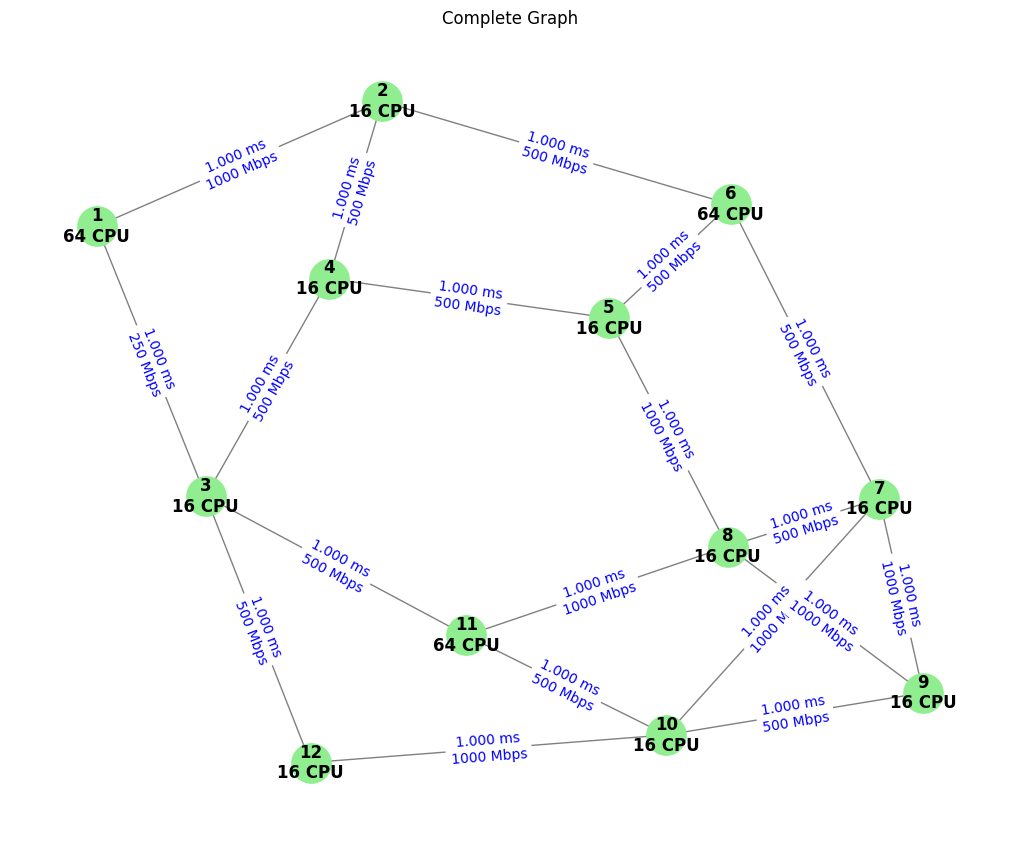

In [10]:
from utils.topology import topology_bayern, draw_graph, topologie_finlande, topology_brazil
from utils.generate_slices import generate_random_slices
from milp.topology_to_instance import build_instance_from_topology
from milp.solver_gurobi import solve_gurobi      
from milp.adapter import MILPResultAdapterGurobi, MILPSequentialAdapter

import pandas as pd

# === Topology ===
G = topologie_finlande()

draw_graph(G)


In [ ]:
# ============================
# Imports (clean and complete)
# ============================

import os
import time
import random
import numpy as np
import networkx as nx
import pandas as pd
from copy import deepcopy
from datetime import datetime
import re

# --- Safe filename function ---
def safe_filename(text):
    """Convert any string into a safe filename: no accents, spaces, or special chars."""
    text = text.lower()
    text = text.replace(" ", "_")
    text = re.sub(r"[^a-z0-9_\-]", "", text)
    return text

# --- Global reproducibility seed ---
GLOBAL_SEED = 42
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
os.environ["PYTHONHASHSEED"] = str(GLOBAL_SEED)

# --- MILP modules ---
from milp.create_instance import create_instance
from milp.solve_gurobi_sequential import (
    solve_gurobi_sequential,
    _get_slice_vl_pairs,
    NODE_ENERGY_WEIGHT,
    LINK_ENERGY_WEIGHT,
)

# --- Topologies ---
from utils.topology import topologie_finlande, topology_brazil

# --- Slice generation ---
from utils.generate_slices import generate_random_slices

# --- Graph generation ---
from utils.generate_graphs import plot_all_routes, plot_cpu_usage

# --- Heuristics ---
from heuristics.a_star import run_astar
from heuristics.run_abo_full_batch import run_abo_full_batch
from heuristics.run_fabo_full_batch import run_fabo_full_batch
from heuristics.best_fit import run_best_fit
from heuristics.first_fit import run_first_fit
from heuristics.a_star_energy_aware import energy_aware_astar

# --- Metrics ---
from utils.metrics import (
    count_accepted_slices,
    compute_energy_new,
    compute_total_bandwidth,
    compute_total_latency,
)

# ============================
# Helper: energy for sequential MILP
# ============================

def compute_seq_milp_energy(instance, seq_result):
    """Compute total node/link energy for the sequential MILP result.

    It uses the same proxy as in solve_gurobi_sequential:
      - Node energy: sum_n (cpu_used_n / CPU_cap[n])
      - Link energy: sum_(u,v) (bw_used_uv / BW_cap[(u,v)])
    """

    total_E_nodes = 0.0
    total_E_links = 0.0

    for s in seq_result["accepted_slices"]:
        res_s = seq_result["slice_results"][s]
        N = instance.N
        E = instance.E
        vl_pairs = _get_slice_vl_pairs(instance, s)

        # ---- Node energy for this slice ----
        node_terms = []
        for n in N:
            cpu_used_n = 0.0
            for i in instance.V_of_s[s]:
                x_val = res_s.values.get(("x", s, i, n), 0.0)
                cpu_used_n += instance.CPU_i[i] * x_val
            cap_n = instance.CPU_cap[n]
            if cap_n > 0:
                node_terms.append(cpu_used_n / cap_n)
        E_nodes_s = NODE_ENERGY_WEIGHT * sum(node_terms)

        # ---- Link energy for this slice ----
        link_terms = []
        for (u, v) in E:
            bw_used_uv = 0.0
            for (i, j) in vl_pairs:
                f_val = res_s.values.get(("f", s, i, j, u, v), 0.0)
                bw_used_uv += f_val
            cap_uv = instance.BW_cap[(u, v)]
            if cap_uv > 0:
                link_terms.append(bw_used_uv / cap_uv)
        E_links_s = LINK_ENERGY_WEIGHT * sum(link_terms)

        total_E_nodes += E_nodes_s
        total_E_links += E_links_s

    return total_E_nodes, total_E_links, (total_E_nodes + total_E_links)


# ============================
# Directories for results
# ============================

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
results_dir = os.path.join("./results", safe_filename(timestamp))
os.makedirs(results_dir, exist_ok=True)

routes_dir = os.path.join(results_dir, "routes")
cpu_dir = os.path.join(results_dir, "cpu_usage")
os.makedirs(routes_dir, exist_ok=True)
os.makedirs(cpu_dir, exist_ok=True)

print(f"[INFO] Results will be saved under: {results_dir}")

# --- Global MILP / experiment parameters ---
MILP_TIME_LIMIT = 300
ENTRY = 6
MAX_MILP_SLICES = 128
MAX_MILP_VNFS_TOTAL = 512

# --- Topology ---
G = topologie_finlande()
ENTRY = 6
pos = nx.spring_layout(G, seed=GLOBAL_SEED)

# --- VNF profiles ---
vnf_profiles = [
    {"cpu": 2,  "throughput": 30, "latency": 80},   # light
    {"cpu": 3,  "throughput": 40, "latency": 110},  # slightly heavier
    {"cpu": 4,  "throughput": 50, "latency": 140},  # medium
    {"cpu": 6,  "throughput": 65, "latency": 180},  # medium-heavy
    {"cpu": 8,  "throughput": 80, "latency": 220},  # heavy
    {"cpu": 10, "throughput": 95, "latency": 260},  # very heavy
]

# --- Base capacities ---
node_capacity_base = {n: G.nodes[n]["cpu"] for n in G.nodes}
link_capacity_base = {(u, v): G[u][v]["bandwidth"] for u, v in G.edges}
link_capacity_base.update({(v, u): G[u][v]["bandwidth"] for u, v in G.edges})
link_latency = {(u, v): G[u][v]["latency"] for u, v in G.edges}
link_latency.update({(v, u): G[u][v]["latency"] for u, v in G.edges})

# --- Parameter grid ---
param_grid = {
    "num_slices": [6, 8, 12, 16, 32],
    "num_vnfs_per_slice": [2, 3, 4, 5, 6],
    "seed": list(range(1)),
}

max_slices = max(param_grid["num_slices"])

# IMPORTANT: reset records before the main loop
records = []

try:
    # ------------------------------------------------------------------
    # Main experiment loop with a fixed pool of slices per (vnf, seed)
    # ------------------------------------------------------------------
    for num_vnfs in param_grid["num_vnfs_per_slice"]:
        for seed in param_grid["seed"]:
            # Fix per-(num_vnfs, seed) randomness
            random.seed(seed)
            np.random.seed(seed)

            print(f"\n[INFO] === Pre-generating slice pool: max_slices={max_slices}, "
                  f"VNFs={num_vnfs}, seed={seed} ===")

            slice_pool = generate_random_slices(
                G,
                vnf_profiles,
                num_slices=max_slices,
                num_vnfs_per_slice=num_vnfs,
                entry=ENTRY,
            )

            if len(slice_pool) < max_slices:
                print(f"[WARN] slice_pool has only {len(slice_pool)} entries (expected {max_slices}).")

            # Sweep number of slices for this (num_vnfs, seed)
            for num_slices in param_grid["num_slices"]:
                total_vnfs = num_slices * num_vnfs

                print(f"\n[INFO] === Running Load Test: {num_slices} slices × "
                      f"{num_vnfs} VNFs (total={total_vnfs}), seed={seed} ===")

                # Use the first num_slices from the fixed pool
                slices = deepcopy(slice_pool[:num_slices])
                method_results = {}
                method_times = {}

                # --- Heuristics ---
                for name, func, args in [
                    ("A*", run_astar, (G, slices, node_capacity_base, link_capacity_base)),
                    ("ABO", run_abo_full_batch, (G, slices, node_capacity_base, link_latency, link_capacity_base)),
                    ("FABO", run_fabo_full_batch, (G, slices, node_capacity_base, link_latency, link_capacity_base)),
                    ("Best Fit", run_best_fit, (G, slices, node_capacity_base, link_capacity_base, link_latency)),
                    ("First Fit", run_first_fit, (G, slices, node_capacity_base, link_capacity_base, link_latency)),
                    ("Energy-Aware A*", energy_aware_astar,
                     (G, slices, node_capacity_base, link_capacity_base, 0.6, 0.4)),
                ]:
                    start = time.time()
                    try:
                        df_res, res_list = func(*args)
                        method_results[name] = res_list
                    except Exception as e:
                        print(f"[ERROR] {name} failed: {e}")
                        method_results[name] = []
                    method_times[name] = time.time() - start

                # --- Sequential MILP (optional, limited by size) ---
                if num_slices <= MAX_MILP_SLICES and total_vnfs <= MAX_MILP_VNFS_TOTAL:
                    try:
                        print(f"\n[INFO][MILP-SEQ] Running Sequential MILP…")
                        start = time.time()

                        # Build instance compatible with solve_gurobi_sequential
                        instance = create_instance(G, slices)
                        instance.entry_node = ENTRY  # kept for compatibility if used elsewhere

                        seq_res = solve_gurobi_sequential(
                            instance,
                            msg=False,
                            time_limit=MILP_TIME_LIMIT,
                        )
                        milp_seq_runtime = time.time() - start

                        # Wrap in adapter so plotting functions can see VNFs and routes
                        adapter_seq = MILPSequentialAdapter(seq_res, instance)
                        result_list_seq = [adapter_seq]

                      
                        method_results["MILP_Sequential"] = result_list_seq
                        method_times["MILP_Sequential"] = milp_seq_runtime

                       
                        accepted_seq = len(seq_res["accepted_slices"])
                        E_nodes_seq, E_links_seq, E_total_seq = compute_seq_milp_energy(
                            instance, seq_res
                        )
                        total_bw_seq = None
                        total_lat_seq = None

                        records.append({
                            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                            "num_slices": num_slices,
                            "num_vnfs_per_slice": num_vnfs,
                            "total_vnfs": total_vnfs,
                            "seed": seed,
                            "method": "MILP_Sequential",
                            "accepted": accepted_seq,
                            "total_energy": E_total_seq,
                            "total_bandwidth": total_bw_seq,
                            "total_latency": total_lat_seq,
                            "runtime_sec": milp_seq_runtime,
                        })

                    except Exception as e:
                        print(f"[ERROR][MILP-SEQ] Failed: {e}")


                # ----------------------------------------
                # Per-scenario visualizations
                # ----------------------------------------
                for method_name, result_list in method_results.items():
                    if not result_list:
                        continue

                    safe_img_name = safe_filename(
                        f"{method_name}_slices{num_slices}_vnfs{num_vnfs}_seed{seed}"
                    )

                    plot_all_routes(
                        G,
                        result_list,
                        title="All routed paths",
                        results_dir=routes_dir,
                        num_slices=num_slices,
                        num_vnfs_per_slice=num_vnfs,
                        seed=seed,
                        method_name=safe_img_name,
                        # pos=pos,  # uncomment if function supports fixed layout
                    )

                # CPU usage plot (all methods for this scenario)
                plot_cpu_usage(
                    G,
                    slices,
                    method_results,
                    results_dir=cpu_dir,
                    num_slices=num_slices,
                    num_vnfs_per_slice=num_vnfs,
                    seed=seed,
                )

                # --- Metrics for heuristics ---
                for method_name, result_list in method_results.items():
                    if not result_list:
                        continue
                    try:
                        accepted = count_accepted_slices(result_list, slices)
                        total_energy = compute_energy_new(
                            result_list, slices, node_capacity_base, link_capacity_base
                        )
                        total_bw = sum(b for b in compute_total_bandwidth(result_list, slices) if b)
                        total_lat = sum(l for l in compute_total_latency(result_list, link_latency) if l)

                        records.append({
                            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                            "num_slices": num_slices,
                            "num_vnfs_per_slice": num_vnfs,
                            "total_vnfs": total_vnfs,
                            "seed": seed,
                            "method": method_name,
                            "accepted": accepted,
                            "total_energy": total_energy,
                            "total_bandwidth": total_bw,
                            "total_latency": total_lat,
                            "runtime_sec": method_times[method_name],
                        })
                    except Exception as e:
                        print(f"[ERROR] Metrics failed for {method_name}, "
                              f"slices={num_slices}, vnfs={num_vnfs}, seed={seed}: {e}")

finally:
    # --- Save results even if something failed ---
    df_results = pd.DataFrame(records)

    if not df_results.empty:
        dup = df_results.groupby(["method", "num_slices", "num_vnfs_per_slice", "seed"]).size()
        print("[CHECK] Max repetitions:", dup.max())
    else:
        print("[WARN] df_results is empty, nothing to group.")

    output_path = os.path.join(results_dir, "scalability_results.csv")
    df_results.to_csv(output_path, index=False)
    print(f"\n[INFO] Results saved to {output_path}")
    print(f"[INFO] records generated: {len(records)}")
    print(f"[INFO] CSV exists? {os.path.exists(output_path)}")


[INFO] Results will be saved under: ./results/2025-12-09_15-00-33

[INFO] === Pre-generating slice pool: max_slices=32, VNFs=2, seed=0 ===

[INFO] === Running Load Test: 6 slices × 2 VNFs (total=12), seed=0 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 6 accepted.


[I

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_a_slices6_vnfs2_seed0_s6_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_abo_slices6_vnfs2_seed0_s6_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_fabo_slices6_vnfs2_seed0_s6_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_best_fit_slices6_vnfs2_seed0_s6_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_first_fit_slices6_vnfs2_seed0_s6_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_energy-aware_a_slices6_vnfs2_seed0_s6_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_milp_sequential_slices6_vnfs2_seed0_s6_v2_seed0.png
[INFO] Saved CPU utilization chart to ./results/2025-12-09_15-00-33/cpu_usage/cpu_utilization_s6_v2_seed0.png

[INFO] === Running Load Test: 8 slices × 2 VNFs (total=16), seed=0 ===

[INFO][

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_a_slices8_vnfs2_seed0_s8_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_abo_slices8_vnfs2_seed0_s8_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_fabo_slices8_vnfs2_seed0_s8_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_best_fit_slices8_vnfs2_seed0_s8_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_first_fit_slices8_vnfs2_seed0_s8_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_energy-aware_a_slices8_vnfs2_seed0_s8_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_milp_sequential_slices8_vnfs2_seed0_s8_v2_seed0.png
[INFO] Saved CPU utilization chart to ./results/2025-12-09_15-00-33/cpu_usage/cpu_utilization_s8_v2_seed0.png

[INFO] === Running Load Test: 12 slices × 2 VNFs (total=24), seed=0 ===

[INFO]

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_a_slices12_vnfs2_seed0_s12_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_abo_slices12_vnfs2_seed0_s12_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_fabo_slices12_vnfs2_seed0_s12_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_best_fit_slices12_vnfs2_seed0_s12_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_first_fit_slices12_vnfs2_seed0_s12_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_energy-aware_a_slices12_vnfs2_seed0_s12_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_milp_sequential_slices12_vnfs2_seed0_s12_v2_seed0.png
[INFO] Saved CPU utilization chart to ./results/2025-12-09_15-00-33/cpu_usage/cpu_utilization_s12_v2_seed0.png

[INFO] === Running Load Test: 16 slices × 2 VNFs (total=32), see

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_a_slices16_vnfs2_seed0_s16_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_abo_slices16_vnfs2_seed0_s16_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_fabo_slices16_vnfs2_seed0_s16_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_best_fit_slices16_vnfs2_seed0_s16_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_first_fit_slices16_vnfs2_seed0_s16_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_energy-aware_a_slices16_vnfs2_seed0_s16_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_milp_sequential_slices16_vnfs2_seed0_s16_v2_seed0.png
[INFO] Saved CPU utilization chart to ./results/2025-12-09_15-00-33/cpu_usage/cpu_utilization_s16_v2_seed0.png

[INFO] === Running Load Test: 32 slices × 2 VNFs (total=64), see

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_a_slices32_vnfs2_seed0_s32_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_abo_slices32_vnfs2_seed0_s32_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_fabo_slices32_vnfs2_seed0_s32_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_best_fit_slices32_vnfs2_seed0_s32_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_first_fit_slices32_vnfs2_seed0_s32_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_energy-aware_a_slices32_vnfs2_seed0_s32_v2_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_milp_sequential_slices32_vnfs2_seed0_s32_v2_seed0.png
[INFO] Saved CPU utilization chart to ./results/2025-12-09_15-00-33/cpu_usage/cpu_utilization_s32_v2_seed0.png

[INFO] === Pre-generating slice pool: max_slices=32, VNFs=3, see

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_a_slices6_vnfs3_seed0_s6_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_abo_slices6_vnfs3_seed0_s6_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_fabo_slices6_vnfs3_seed0_s6_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_best_fit_slices6_vnfs3_seed0_s6_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_first_fit_slices6_vnfs3_seed0_s6_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_energy-aware_a_slices6_vnfs3_seed0_s6_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_milp_sequential_slices6_vnfs3_seed0_s6_v3_seed0.png
[INFO] Saved CPU utilization chart to ./results/2025-12-09_15-00-33/cpu_usage/cpu_utilization_s6_v3_seed0.png

[INFO] === Running Load Test: 8 slices × 3 VNFs (total=24), seed=0 ===

[INFO][

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_a_slices8_vnfs3_seed0_s8_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_abo_slices8_vnfs3_seed0_s8_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_fabo_slices8_vnfs3_seed0_s8_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_best_fit_slices8_vnfs3_seed0_s8_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_first_fit_slices8_vnfs3_seed0_s8_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_energy-aware_a_slices8_vnfs3_seed0_s8_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_milp_sequential_slices8_vnfs3_seed0_s8_v3_seed0.png
[INFO] Saved CPU utilization chart to ./results/2025-12-09_15-00-33/cpu_usage/cpu_utilization_s8_v3_seed0.png

[INFO] === Running Load Test: 12 slices × 3 VNFs (total=36), seed=0 ===

[INFO]

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_a_slices12_vnfs3_seed0_s12_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_abo_slices12_vnfs3_seed0_s12_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_fabo_slices12_vnfs3_seed0_s12_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_best_fit_slices12_vnfs3_seed0_s12_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_first_fit_slices12_vnfs3_seed0_s12_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_energy-aware_a_slices12_vnfs3_seed0_s12_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_milp_sequential_slices12_vnfs3_seed0_s12_v3_seed0.png
[INFO] Saved CPU utilization chart to ./results/2025-12-09_15-00-33/cpu_usage/cpu_utilization_s12_v3_seed0.png

[INFO] === Running Load Test: 16 slices × 3 VNFs (total=48), see

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_a_slices16_vnfs3_seed0_s16_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_abo_slices16_vnfs3_seed0_s16_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_fabo_slices16_vnfs3_seed0_s16_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_best_fit_slices16_vnfs3_seed0_s16_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_first_fit_slices16_vnfs3_seed0_s16_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_energy-aware_a_slices16_vnfs3_seed0_s16_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_milp_sequential_slices16_vnfs3_seed0_s16_v3_seed0.png
[INFO] Saved CPU utilization chart to ./results/2025-12-09_15-00-33/cpu_usage/cpu_utilization_s16_v3_seed0.png

[INFO] === Running Load Test: 32 slices × 3 VNFs (total=96), see

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_a_slices32_vnfs3_seed0_s32_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_abo_slices32_vnfs3_seed0_s32_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_fabo_slices32_vnfs3_seed0_s32_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_best_fit_slices32_vnfs3_seed0_s32_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_first_fit_slices32_vnfs3_seed0_s32_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_energy-aware_a_slices32_vnfs3_seed0_s32_v3_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_milp_sequential_slices32_vnfs3_seed0_s32_v3_seed0.png
[INFO] Saved CPU utilization chart to ./results/2025-12-09_15-00-33/cpu_usage/cpu_utilization_s32_v3_seed0.png

[INFO] === Pre-generating slice pool: max_slices=32, VNFs=4, see

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_a_slices6_vnfs4_seed0_s6_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_abo_slices6_vnfs4_seed0_s6_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_fabo_slices6_vnfs4_seed0_s6_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_best_fit_slices6_vnfs4_seed0_s6_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_first_fit_slices6_vnfs4_seed0_s6_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_energy-aware_a_slices6_vnfs4_seed0_s6_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_milp_sequential_slices6_vnfs4_seed0_s6_v4_seed0.png
[INFO] Saved CPU utilization chart to ./results/2025-12-09_15-00-33/cpu_usage/cpu_utilization_s6_v4_seed0.png

[INFO] === Running Load Test: 8 slices × 4 VNFs (total=32), seed=0 ===

[INFO][

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_a_slices8_vnfs4_seed0_s8_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_abo_slices8_vnfs4_seed0_s8_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_fabo_slices8_vnfs4_seed0_s8_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_best_fit_slices8_vnfs4_seed0_s8_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_first_fit_slices8_vnfs4_seed0_s8_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_energy-aware_a_slices8_vnfs4_seed0_s8_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_milp_sequential_slices8_vnfs4_seed0_s8_v4_seed0.png
[INFO] Saved CPU utilization chart to ./results/2025-12-09_15-00-33/cpu_usage/cpu_utilization_s8_v4_seed0.png

[INFO] === Running Load Test: 12 slices × 4 VNFs (total=48), seed=0 ===

[INFO]

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_a_slices12_vnfs4_seed0_s12_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_abo_slices12_vnfs4_seed0_s12_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_fabo_slices12_vnfs4_seed0_s12_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_best_fit_slices12_vnfs4_seed0_s12_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_first_fit_slices12_vnfs4_seed0_s12_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_energy-aware_a_slices12_vnfs4_seed0_s12_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_milp_sequential_slices12_vnfs4_seed0_s12_v4_seed0.png
[INFO] Saved CPU utilization chart to ./results/2025-12-09_15-00-33/cpu_usage/cpu_utilization_s12_v4_seed0.png

[INFO] === Running Load Test: 16 slices × 4 VNFs (total=64), see

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_a_slices16_vnfs4_seed0_s16_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_abo_slices16_vnfs4_seed0_s16_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_fabo_slices16_vnfs4_seed0_s16_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_best_fit_slices16_vnfs4_seed0_s16_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_first_fit_slices16_vnfs4_seed0_s16_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_energy-aware_a_slices16_vnfs4_seed0_s16_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_milp_sequential_slices16_vnfs4_seed0_s16_v4_seed0.png
[INFO] Saved CPU utilization chart to ./results/2025-12-09_15-00-33/cpu_usage/cpu_utilization_s16_v4_seed0.png

[INFO] === Running Load Test: 32 slices × 4 VNFs (total=128), se

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_a_slices32_vnfs4_seed0_s32_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_abo_slices32_vnfs4_seed0_s32_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_fabo_slices32_vnfs4_seed0_s32_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_best_fit_slices32_vnfs4_seed0_s32_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_first_fit_slices32_vnfs4_seed0_s32_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_energy-aware_a_slices32_vnfs4_seed0_s32_v4_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_milp_sequential_slices32_vnfs4_seed0_s32_v4_seed0.png
[INFO] Saved CPU utilization chart to ./results/2025-12-09_15-00-33/cpu_usage/cpu_utilization_s32_v4_seed0.png

[INFO] === Pre-generating slice pool: max_slices=32, VNFs=5, see

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_a_slices6_vnfs5_seed0_s6_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_abo_slices6_vnfs5_seed0_s6_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_fabo_slices6_vnfs5_seed0_s6_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_best_fit_slices6_vnfs5_seed0_s6_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_first_fit_slices6_vnfs5_seed0_s6_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_energy-aware_a_slices6_vnfs5_seed0_s6_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_milp_sequential_slices6_vnfs5_seed0_s6_v5_seed0.png
[INFO] Saved CPU utilization chart to ./results/2025-12-09_15-00-33/cpu_usage/cpu_utilization_s6_v5_seed0.png

[INFO] === Running Load Test: 8 slices × 5 VNFs (total=40), seed=0 ===

[INFO][

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_a_slices8_vnfs5_seed0_s8_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_abo_slices8_vnfs5_seed0_s8_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_fabo_slices8_vnfs5_seed0_s8_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_best_fit_slices8_vnfs5_seed0_s8_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_first_fit_slices8_vnfs5_seed0_s8_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_energy-aware_a_slices8_vnfs5_seed0_s8_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_milp_sequential_slices8_vnfs5_seed0_s8_v5_seed0.png
[INFO] Saved CPU utilization chart to ./results/2025-12-09_15-00-33/cpu_usage/cpu_utilization_s8_v5_seed0.png

[INFO] === Running Load Test: 12 slices × 5 VNFs (total=60), seed=0 ===

[INFO]

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_a_slices12_vnfs5_seed0_s12_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_abo_slices12_vnfs5_seed0_s12_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_fabo_slices12_vnfs5_seed0_s12_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_best_fit_slices12_vnfs5_seed0_s12_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_first_fit_slices12_vnfs5_seed0_s12_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_energy-aware_a_slices12_vnfs5_seed0_s12_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_milp_sequential_slices12_vnfs5_seed0_s12_v5_seed0.png
[INFO] Saved CPU utilization chart to ./results/2025-12-09_15-00-33/cpu_usage/cpu_utilization_s12_v5_seed0.png

[INFO] === Running Load Test: 16 slices × 5 VNFs (total=80), see

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_a_slices16_vnfs5_seed0_s16_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_abo_slices16_vnfs5_seed0_s16_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_fabo_slices16_vnfs5_seed0_s16_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_best_fit_slices16_vnfs5_seed0_s16_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_first_fit_slices16_vnfs5_seed0_s16_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_energy-aware_a_slices16_vnfs5_seed0_s16_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_milp_sequential_slices16_vnfs5_seed0_s16_v5_seed0.png
[INFO] Saved CPU utilization chart to ./results/2025-12-09_15-00-33/cpu_usage/cpu_utilization_s16_v5_seed0.png

[INFO] === Running Load Test: 32 slices × 5 VNFs (total=160), se

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_a_slices32_vnfs5_seed0_s32_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_abo_slices32_vnfs5_seed0_s32_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_fabo_slices32_vnfs5_seed0_s32_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_best_fit_slices32_vnfs5_seed0_s32_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_first_fit_slices32_vnfs5_seed0_s32_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_energy-aware_a_slices32_vnfs5_seed0_s32_v5_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_milp_sequential_slices32_vnfs5_seed0_s32_v5_seed0.png
[INFO] Saved CPU utilization chart to ./results/2025-12-09_15-00-33/cpu_usage/cpu_utilization_s32_v5_seed0.png

[INFO] === Pre-generating slice pool: max_slices=32, VNFs=6, see

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_a_slices6_vnfs6_seed0_s6_v6_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_abo_slices6_vnfs6_seed0_s6_v6_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_fabo_slices6_vnfs6_seed0_s6_v6_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_best_fit_slices6_vnfs6_seed0_s6_v6_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_first_fit_slices6_vnfs6_seed0_s6_v6_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_energy-aware_a_slices6_vnfs6_seed0_s6_v6_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_milp_sequential_slices6_vnfs6_seed0_s6_v6_seed0.png
[INFO] Saved CPU utilization chart to ./results/2025-12-09_15-00-33/cpu_usage/cpu_utilization_s6_v6_seed0.png

[INFO] === Running Load Test: 8 slices × 6 VNFs (total=48), seed=0 ===

[INFO][

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_a_slices8_vnfs6_seed0_s8_v6_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_abo_slices8_vnfs6_seed0_s8_v6_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_fabo_slices8_vnfs6_seed0_s8_v6_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_best_fit_slices8_vnfs6_seed0_s8_v6_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_first_fit_slices8_vnfs6_seed0_s8_v6_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_energy-aware_a_slices8_vnfs6_seed0_s8_v6_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_milp_sequential_slices8_vnfs6_seed0_s8_v6_seed0.png
[INFO] Saved CPU utilization chart to ./results/2025-12-09_15-00-33/cpu_usage/cpu_utilization_s8_v6_seed0.png

[INFO] === Running Load Test: 12 slices × 6 VNFs (total=72), seed=0 ===

[INFO]

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_a_slices12_vnfs6_seed0_s12_v6_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_abo_slices12_vnfs6_seed0_s12_v6_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_fabo_slices12_vnfs6_seed0_s12_v6_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_best_fit_slices12_vnfs6_seed0_s12_v6_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_first_fit_slices12_vnfs6_seed0_s12_v6_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_energy-aware_a_slices12_vnfs6_seed0_s12_v6_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_milp_sequential_slices12_vnfs6_seed0_s12_v6_seed0.png
[INFO] Saved CPU utilization chart to ./results/2025-12-09_15-00-33/cpu_usage/cpu_utilization_s12_v6_seed0.png

[INFO] === Running Load Test: 16 slices × 6 VNFs (total=96), see

/home/cecilia/5g-slicing-energy-effiiciency/simulator/utils/generate_graphs.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_a_slices16_vnfs6_seed0_s16_v6_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_abo_slices16_vnfs6_seed0_s16_v6_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_fabo_slices16_vnfs6_seed0_s16_v6_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_best_fit_slices16_vnfs6_seed0_s16_v6_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_first_fit_slices16_vnfs6_seed0_s16_v6_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_energy-aware_a_slices16_vnfs6_seed0_s16_v6_seed0.png
[INFO] Saved route plot to ./results/2025-12-09_15-00-33/routes/routes_milp_sequential_slices16_vnfs6_seed0_s16_v6_seed0.png
[INFO] Saved CPU utilization chart to ./results/2025-12-09_15-00-33/cpu_usage/cpu_utilization_s16_v6_seed0.png

[INFO] === Running Load Test: 32 slices × 6 VNFs (total=192), se

[INFO] Linhas após filtrar métodos: 175
[INFO] Linhas após filtrar 100% aceitação: 120


,timestamp,num_slices,num_vnfs_per_slice,total_vnfs,seed,method,accepted,total_energy,total_bandwidth,total_latency,runtime_sec,acceptance_rate
0,2025-12-09 18:42:28,8,2,16,1,MILP_Sequential,8,1.345000,NaN,NaN,0.069197,1.0
1,2025-12-09 18:42:37,8,2,16,1,A*,8,9.230000,240.0,8.0,0.078109,1.0
2,2025-12-09 18:42:37,8,2,16,1,ABO,8,4.615000,240.0,16.0,7.565059,1.0
3,2025-12-09 18:42:37,8,2,16,1,FABO,8,17.156875,240.0,16.0,7.626298,1.0
4,2025-12-09 18:42:37,8,2,16,1,Best Fit,8,7.230000,240.0,8.0,0.030037,1.0



=== Accepted slices vs num_slices (100% acceptance, VNFs=2) ===


method,A*,ABO,Best Fit,Energy-Aware A*,FABO,First Fit,MILP_Sequential
num_slices,,,,,,,
8,8.0,8.0,8.0,8.0,8.0,8.0,8.0
16,16.0,16.0,16.0,16.0,16.0,16.0,16.0
32,32.0,32.0,32.0,32.0,32.0,32.0,32.0
64,NaN,NaN,NaN,64.0,64.0,NaN,64.0



=== Total energy vs num_slices (100% acceptance, VNFs=2) ===


method,A*,ABO,Best Fit,Energy-Aware A*,FABO,First Fit,MILP_Sequential
num_slices,,,,,,,
8,9.230000,4.61500,7.230000,9.230000,17.156875,7.26000,1.34500
16,13.349375,16.16375,13.349375,13.349375,21.253750,13.85000,2.69000
32,22.883125,32.19750,20.883125,24.943125,34.083125,27.71875,6.11375
64,NaN,NaN,NaN,47.125625,52.842500,NaN,15.87750


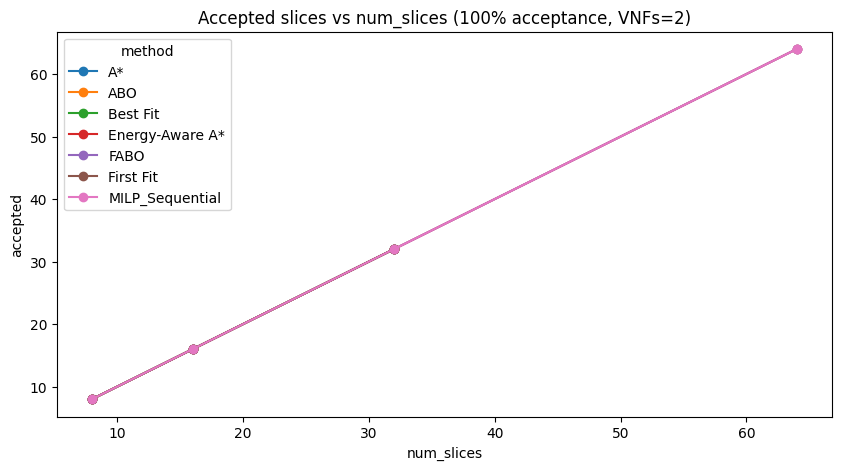

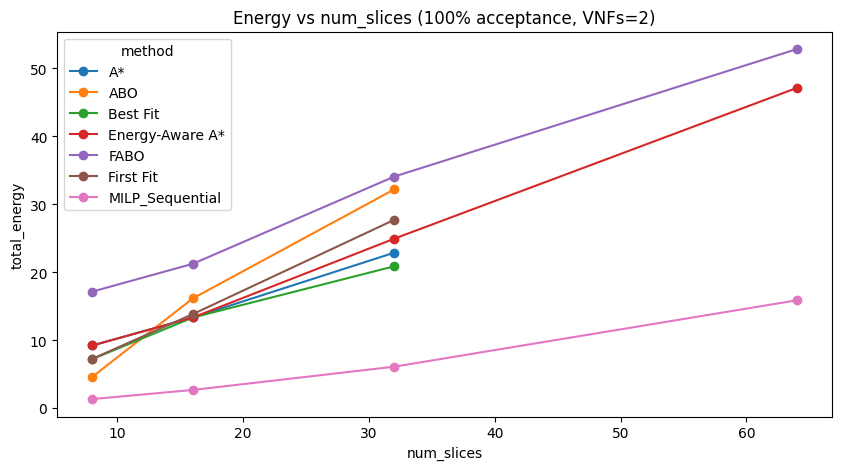

In [6]:
import pandas as pd

# Carregar o CSV
df_results = pd.read_csv("./results/2025-12-09_18-42-13/scalability_results.csv")

# Número de VNFs por slice que você quer analisar
vnf_len = 2   # ajuste para 2,3,4,5,6…

# Filtrar somente VNFs desejado
df_exp = df_results[df_results["num_vnfs_per_slice"] == vnf_len].copy()

# Criar acceptance_rate
df_exp["acceptance_rate"] = df_exp["accepted"] / df_exp["num_slices"]

# Filtrar apenas métodos desejados
METHODS_ALLOWED = ["A*", "ABO", "FABO"]
# Captura também MILP, pode ser MILP_Sequential, MILP_Gurobi, etc.
#df_exp = df_exp[df_exp["method"].isin(METHODS_ALLOWED) | df_exp["method"].str.contains("MILP")]

print("[INFO] Linhas após filtrar métodos:", len(df_exp))

# Filtrar cenários com 100% aceitação
df_ok = df_exp[df_exp["acceptance_rate"] == 1.0].copy()

print("[INFO] Linhas após filtrar 100% aceitação:", len(df_ok))
display(df_ok.head())

# ==============================
# 1) Accepted slices vs num_slices (100% acceptance)
# ==============================

pivot_acc = df_ok.pivot_table(
    index="num_slices",
    columns="method",
    values="accepted",
    aggfunc="mean",
).sort_index()

print("\n=== Accepted slices vs num_slices (100% acceptance, VNFs={}) ===".format(vnf_len))
display(pivot_acc)

# ==============================
# 2) Total energy vs num_slices (100% acceptance)
# ==============================

pivot_energy = df_ok.pivot_table(
    index="num_slices",
    columns="method",
    values="total_energy",
    aggfunc="mean",
).sort_index()

print("\n=== Total energy vs num_slices (100% acceptance, VNFs={}) ===".format(vnf_len))
display(pivot_energy)

# ==============================
# PLOTS
# ==============================

# Accepted slices plot
try:
    ax = pivot_acc.plot(marker="o", figsize=(10, 5),
        title=f"Accepted slices vs num_slices (100% acceptance, VNFs={vnf_len})")
    ax.set_xlabel("num_slices")
    ax.set_ylabel("accepted")
except Exception as e:
    print("[WARN] Could not plot acceptance:", e)

# Energy plot
try:
    ax = pivot_energy.plot(marker="o", figsize=(10, 5),
        title=f"Energy vs num_slices (100% acceptance, VNFs={vnf_len})")
    ax.set_xlabel("num_slices")
    ax.set_ylabel("total_energy")
except Exception as e:
    print("[WARN] Could not plot energy:", e)


[INFO] Linhas após filtrar métodos: 75
[INFO] Linhas após filtrar 100% aceitação: 50


,timestamp,num_slices,num_vnfs_per_slice,total_vnfs,seed,method,accepted,total_energy,total_bandwidth,total_latency,runtime_sec,acceptance_rate
1,2025-12-09 18:42:37,8,2,16,1,A*,8,9.230000,240.0,8.0,0.078109,1.0
2,2025-12-09 18:42:37,8,2,16,1,ABO,8,4.615000,240.0,16.0,7.565059,1.0
3,2025-12-09 18:42:37,8,2,16,1,FABO,8,17.156875,240.0,16.0,7.626298,1.0
8,2025-12-09 18:43:15,16,2,32,1,A*,16,13.349375,510.0,17.0,0.155763,1.0
9,2025-12-09 18:43:15,16,2,32,1,ABO,16,16.163750,480.0,32.0,13.639276,1.0



=== Accepted slices vs num_slices (100% acceptance, VNFs=2) ===


method,A*,ABO,FABO
num_slices,,,
8,8.0,8.0,8.0
16,16.0,16.0,16.0
32,32.0,32.0,32.0
64,NaN,NaN,64.0



=== Total energy vs num_slices (100% acceptance, VNFs=2) ===


method,A*,ABO,FABO
num_slices,,,
8,9.230000,4.61500,17.156875
16,13.349375,16.16375,21.253750
32,22.883125,32.19750,34.083125
64,NaN,NaN,52.842500


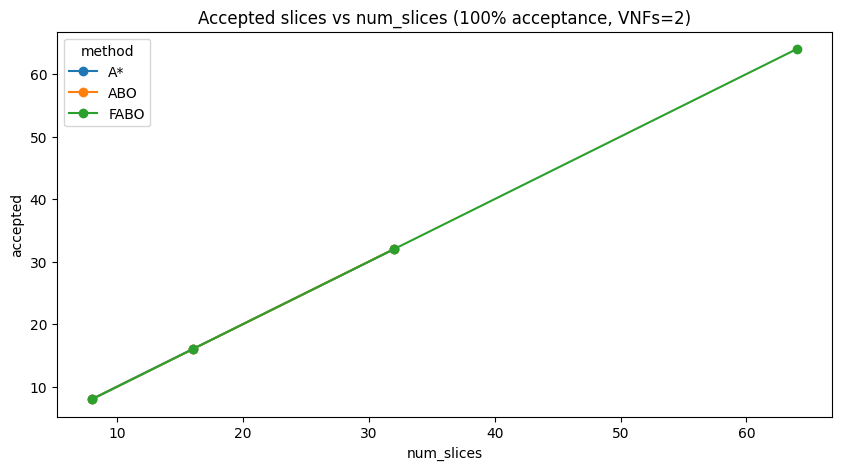

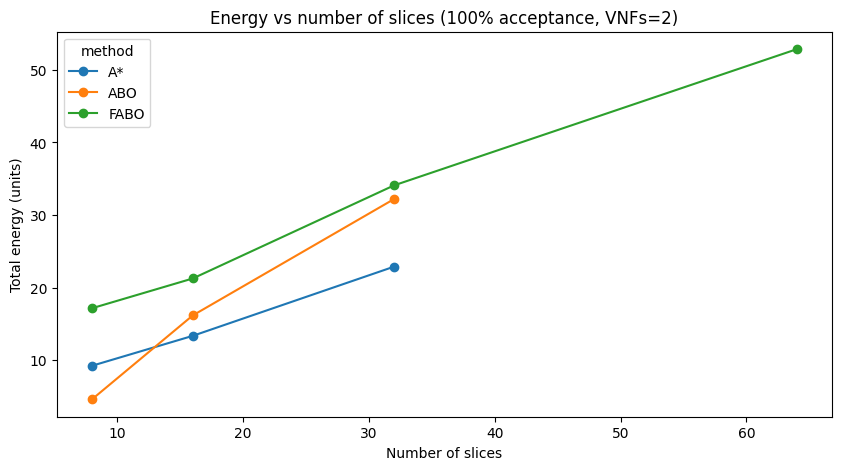

In [17]:
import pandas as pd

# Carregar o CSV
df_results = pd.read_csv("./results/2025-12-09_18-42-13/scalability_results.csv")

# Número de VNFs por slice que você quer analisar
vnf_len = 2   # ajuste para 2,3,4,5,6…

# Filtrar somente VNFs desejado
df_exp = df_results[df_results["num_vnfs_per_slice"] == vnf_len].copy()

# Criar acceptance_rate
df_exp["acceptance_rate"] = df_exp["accepted"] / df_exp["num_slices"]

# Filtrar apenas métodos desejados — sem MILP
METHODS_ALLOWED = ["A*", "ABO", "FABO"]
df_exp = df_exp[df_exp["method"].isin(METHODS_ALLOWED)]

print("[INFO] Linhas após filtrar métodos:", len(df_exp))

# Filtrar cenários com 100% aceitação
df_ok = df_exp[df_exp["acceptance_rate"] == 1.0].copy()

print("[INFO] Linhas após filtrar 100% aceitação:", len(df_ok))
display(df_ok.head())

# ==============================
# 1) Accepted slices vs num_slices (100% acceptance)
# ==============================

pivot_acc = df_ok.pivot_table(
    index="num_slices",
    columns="method",
    values="accepted",
    aggfunc="mean",
).sort_index()

print("\n=== Accepted slices vs num_slices (100% acceptance, VNFs={}) ===".format(vnf_len))
display(pivot_acc)

# ==============================
# 2) Total energy vs num_slices (100% acceptance)
# ==============================

pivot_energy = df_ok.pivot_table(
    index="num_slices",
    columns="method",
    values="total_energy",
    aggfunc="mean",
).sort_index()

print("\n=== Total energy vs num_slices (100% acceptance, VNFs={}) ===".format(vnf_len))
display(pivot_energy)

# ==============================
# PLOTS
# ==============================

# Accepted slices plot
try:
    ax = pivot_acc.plot(marker="o", figsize=(10, 5),
        title=f"Accepted slices vs num_slices (100% acceptance, VNFs={vnf_len})")
    ax.set_xlabel("num_slices")
    ax.set_ylabel("accepted")
except Exception as e:
    print("[WARN] Could not plot acceptance:", e)

# Energy plot
try:
    ax = pivot_energy.plot(marker="o", figsize=(10, 5),
        title=f"Energy vs number of slices (100% acceptance, VNFs={vnf_len})")
    ax.set_xlabel("Number of slices")
    ax.set_ylabel("Total energy (units)")
except Exception as e:
    print("[WARN] Could not plot energy:", e)


[INFO] Tabela de média de aceitação:


method,A*,ABO,FABO
num_slices,,,
8,1.00000,0.950000,0.975000
16,0.85000,0.775000,0.762500
32,0.63750,0.587500,0.581250
64,0.41250,0.378125,0.393750
128,0.20625,0.189062,0.196875


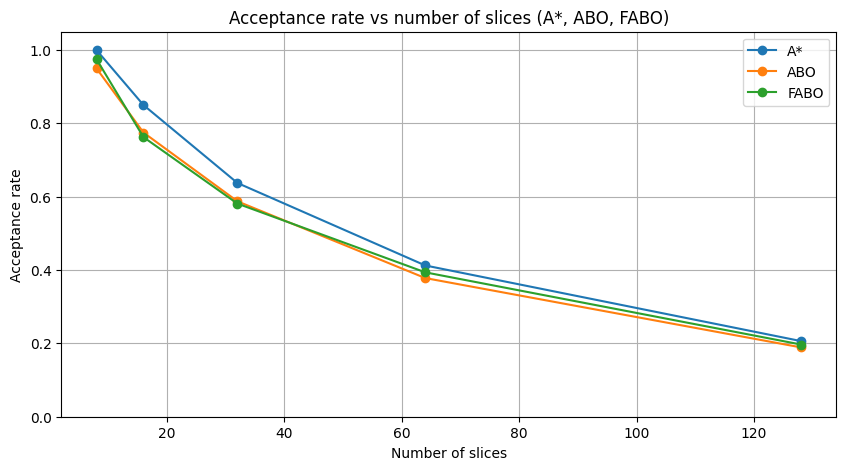

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar o CSV
df_results = pd.read_csv("./results/2025-12-09_18-42-13/scalability_results.csv")

# Filtrar apenas métodos desejados
METHODS_ALLOWED = ["A*", "ABO", "FABO"]
df_exp = df_results[df_results["method"].isin(METHODS_ALLOWED)].copy()

# Criar acceptance_rate
df_exp["acceptance_rate"] = df_exp["accepted"] / df_exp["num_slices"]

# Agrupar por número de slices e método → média das seeds
pivot_acc = df_exp.pivot_table(
    index="num_slices",
    columns="method",
    values="acceptance_rate",
    aggfunc="mean"
).sort_index()

print("[INFO] Tabela de média de aceitação:")
display(pivot_acc)

# ==============================
# PLOT
# ==============================

plt.figure(figsize=(10, 5))
for method in METHODS_ALLOWED:
    if method in pivot_acc.columns:
        plt.plot(
            pivot_acc.index,
            pivot_acc[method],
            marker="o",
            label=method
        )

plt.xlabel("Number of slices")
plt.ylabel("Acceptance rate")
plt.title("Acceptance rate vs number of slices (A*, ABO, FABO)")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.show()


Seeds encontradas: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]


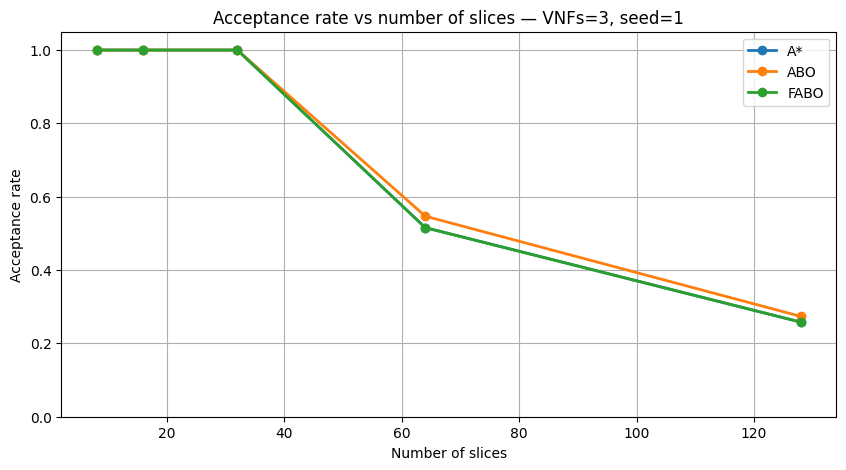

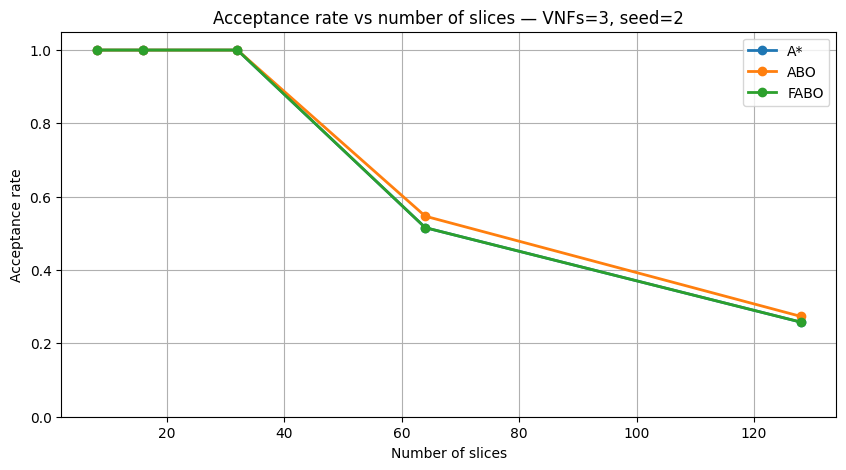

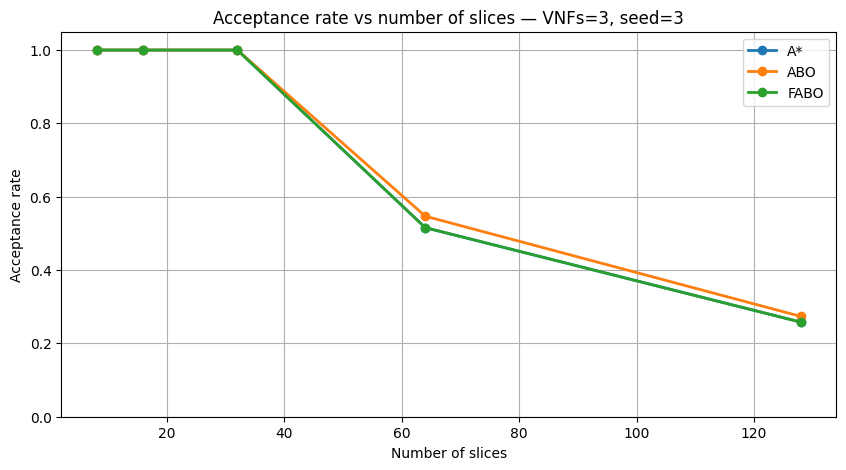

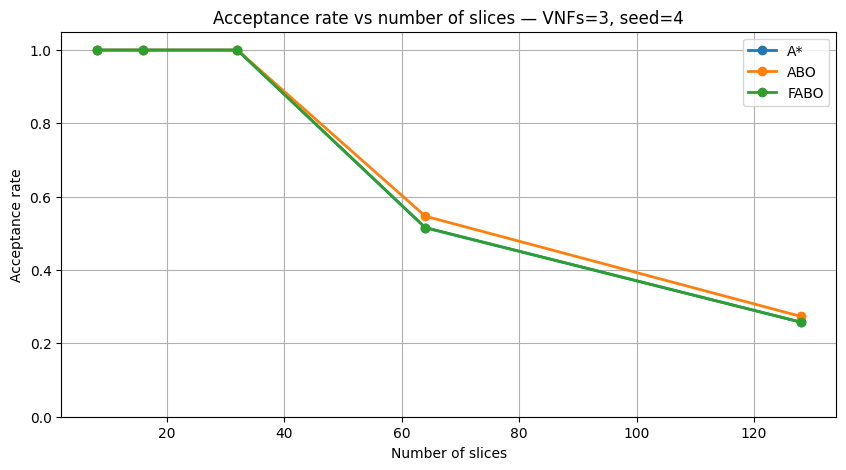

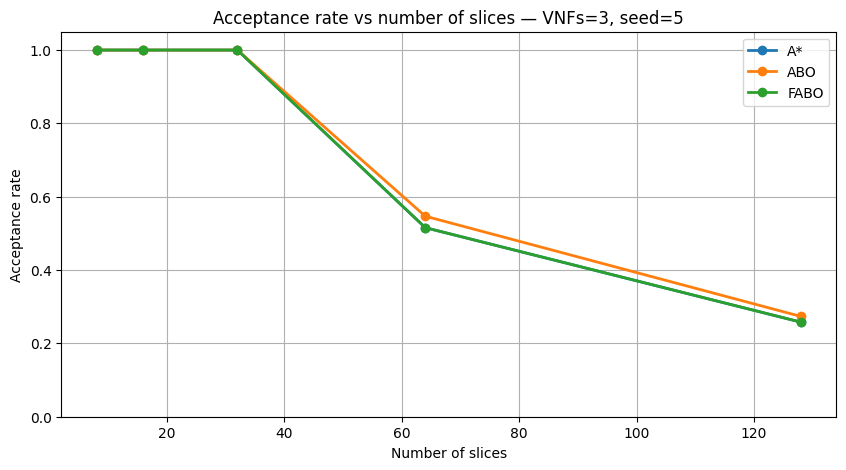

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar o CSV
df_results = pd.read_csv("./results/2025-12-09_18-42-13/scalability_results.csv")

# Filtrar apenas VNFs = 3
vnf_len = 3
df_exp = df_results[df_results["num_vnfs_per_slice"] == vnf_len].copy()

# Métodos desejados
METHODS_ALLOWED = ["A*", "ABO", "FABO"]

df_exp = df_exp[df_exp["method"].isin(METHODS_ALLOWED)]

# Criar acceptance_rate
df_exp["acceptance_rate"] = df_exp["accepted"] / df_exp["num_slices"]

# Listar seeds disponíveis
seeds = sorted(df_exp["seed"].unique())
print("Seeds encontradas:", seeds)

# ==============================
# PLOT POR SEED
# ==============================
for s in seeds:
    df_s = df_exp[df_exp["seed"] == s]

    pivot_acc = df_s.pivot_table(
        index="num_slices",
        columns="method",
        values="acceptance_rate",
        aggfunc="mean"
    ).sort_index()

    plt.figure(figsize=(10, 5))
    for method in METHODS_ALLOWED:
        if method in pivot_acc.columns:
            plt.plot(
                pivot_acc.index,
                pivot_acc[method],
                marker="o",
                linewidth=2,
                label=method
            )

    plt.xlabel("Number of slices")
    plt.ylabel("Acceptance rate")
    plt.title(f"Acceptance rate vs number of slices — VNFs={vnf_len}, seed={s}")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.show()


Seeds encontradas: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]


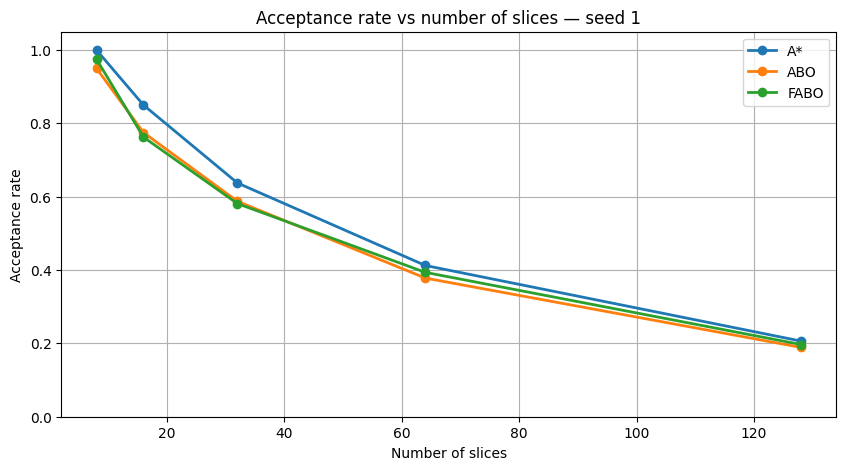

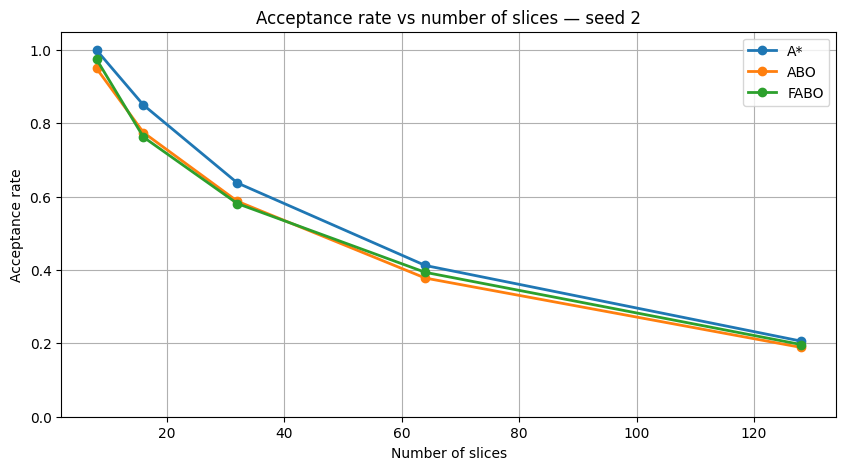

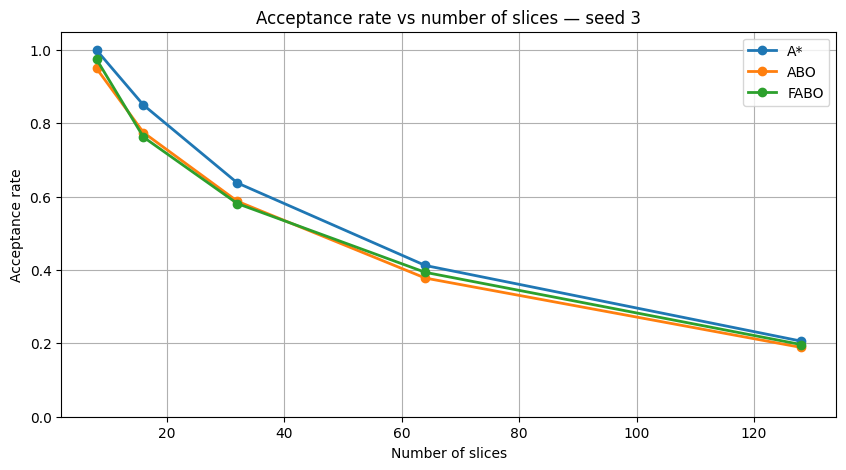

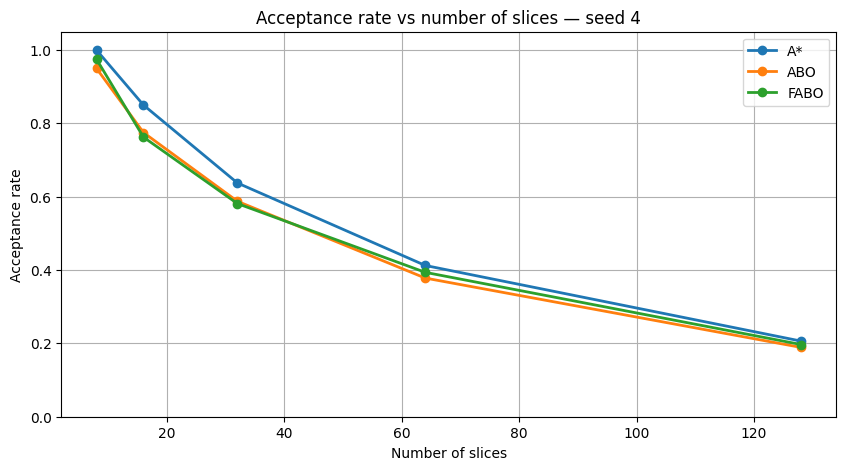

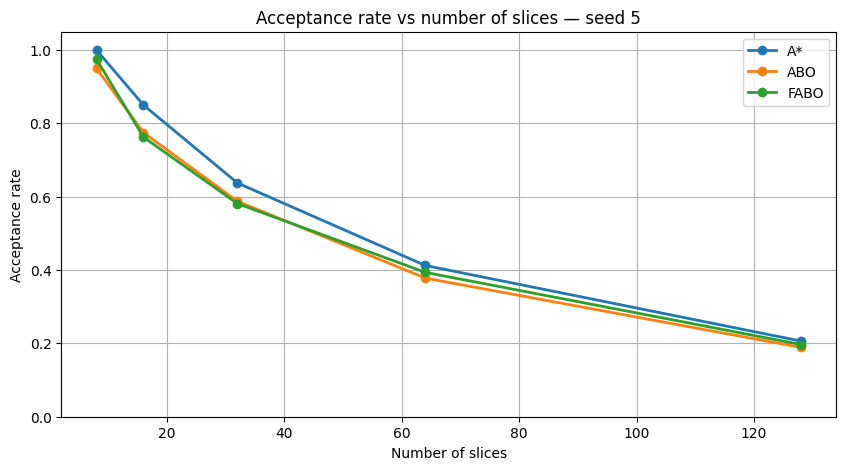

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar o CSV
df_results = pd.read_csv("./results/2025-12-09_18-42-13/scalability_results.csv")

# Métodos desejados
METHODS_ALLOWED = ["A*", "ABO", "FABO"]

df_exp = df_results[df_results["method"].isin(METHODS_ALLOWED)].copy()

# Criar acceptance_rate
df_exp["acceptance_rate"] = df_exp["accepted"] / df_exp["num_slices"]

# Listar seeds disponíveis
seeds = sorted(df_exp["seed"].unique())
print("Seeds encontradas:", seeds)

# ==============================
# PLOT POR SEED
# ==============================
for s in seeds:
    df_s = df_exp[df_exp["seed"] == s]

    pivot_acc = df_s.pivot_table(
        index="num_slices",
        columns="method",
        values="acceptance_rate",
        aggfunc="mean"
    ).sort_index()

    plt.figure(figsize=(10, 5))
    for method in METHODS_ALLOWED:
        if method in pivot_acc.columns:
            plt.plot(
                pivot_acc.index,
                pivot_acc[method],
                marker="o",
                linewidth=2,
                label=method
            )

    plt.xlabel("Number of slices")
    plt.ylabel("Acceptance rate")
    plt.title(f"Acceptance rate vs number of slices — seed {s}")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.show()


In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Find latest results directory
results_base = "./results"
dirs = [d for d in os.listdir(results_base) if os.path.isdir(os.path.join(results_base, d))]
if not dirs:
    raise RuntimeError("No results found in ./results")

latest = sorted(dirs)[-1]
csv_path = os.path.join(results_base, latest, "scalability_results.csv")

df = pd.read_csv(csv_path)

# Prepare plot: total_energy vs accepted, grouped by method
methods = df["method"].unique()

plt.figure(figsize=(10,6))

for m in methods:
    sub = df[df["method"] == m]
    plt.plot(sub["accepted"], sub["total_energy"], marker="o", label=m)

plt.xlabel("Accepted slices")
plt.ylabel("Total energy")
plt.title("Energy vs Accepted Slices for All Methods")
plt.legend()
plt.tight_layout()

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: './results/2025-12-11_15-27-34/scalability_results.csv'